In [1]:
import wradlib as wrl
import matplotlib.pyplot as pl
import numpy as np
import xarray as xr
import os

os.environ["WRADLIB_DATA"] = r"/home/aniket/infocusp/anthromet/weather-tools-aniket/dump/dwd_radolan"

wrl.__version__

/home/aniket/miniconda3/envs/weather-tools/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.18.0'

In [34]:
# util functions
import rasterio
from rasterio.plot import show
def view(uri, band=1):
    img = rasterio.open(uri)
    show(img.read(band), title=f"file: {uri} band: {band}")  

In [20]:
def get_crs_and_transform(uri):
    with rasterio.open(uri, 'r') as f:
        dtype, crs, transform = (f.profile.get(key) for key in ['dtype', 'crs', 'transform'])

    return crs, transform

# Convert coordidate from one CRS to Another

In [23]:
print(get_crs_and_transform("/home/aniket/infocusp/anthromet/weather-tools-aniket/dump/test8.tif"))
print(get_crs_and_transform("/home/aniket/infocusp/anthromet/weather-tools-aniket/dump/test8_reproject.tif"))

(CRS.from_wkt('PROJCS["Radolan Projection",GEOGCS["Radolan Coordinate System",DATUM["Radolan_Kugel",SPHEROID["Erdkugel",6370040,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",60],PARAMETER["central_meridian",10],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["kilometre",1000],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH]]'), Affine(0.9990909090909091, 0.0, -543.4621669218559,
       0.0, -0.9991666666666666, -3609.644724265573))
(CRS.from_epsg(4326), Affine(0.011211006081154341, 0.0, 1.4379496136708065,
       0.0, -0.011211006081154341, 56.21582143506452))


In [12]:
import rasterio.warp
from rasterio.crs import CRS
from shapely.geometry import box

xmin, ymin, xmax, ymax = -543.462, -4808.645, 555.538, -3609.645

proj_osr = wrl.georef.create_osr("dwd-radolan")
wkt_str = proj_osr.ExportToWkt()
radolan_crs = rasterio.crs.CRS.from_wkt(wkt_str)


bounds =  (xmin, ymin, xmax, ymax)

feature = {
    "type": "Polygon",
    "coordinates": [
       [[xmax, ymin], 
        [xmax, ymax], 
        [xmin, ymax], 
        [xmin, ymin], 
        [xmax, ymin]]
   ]
}

# Project the feature to the desired CRS
feature_proj = rasterio.warp.transform_geom(
    radolan_crs,
    CRS.from_epsg(4326),
    feature
)

feature_proj



{'type': 'Polygon',
 'coordinates': [[(16.590109067531017, 45.68453072938217),
   (18.749387474912957, 55.841119359005226),
   (1.43795284883433, 55.85712916259448),
   (3.5519236265708116, 45.695868370326906),
   (16.590109067531017, 45.68453072938217)]]}

In [17]:
import wradlib as wrl

crs = wrl.georef.create_osr("dwd-radolan") 
print(crs.ExportToWkt())
wkt_str = proj_osr.ExportToWkt()
radolan_crs = rasterio.crs.CRS.from_wkt(wkt_str)
radolan_crs

PROJCS["Radolan Projection",GEOGCS["Radolan Coordinate System",DATUM["Radolan_Kugel",SPHEROID["Erdkugel",6370040,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",60],PARAMETER["central_meridian",10],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["kilometre",1000,AUTHORITY["EPSG","9036"]],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH]]


CRS.from_wkt('PROJCS["Radolan Projection",GEOGCS["Radolan Coordinate System",DATUM["Radolan_Kugel",SPHEROID["Erdkugel",6370040,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",60],PARAMETER["central_meridian",10],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["kilometre",1000,AUTHORITY["EPSG","9036"]],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH]]')

# Reading Dataset & Plotting
using wradlib data is read. can't read *.tar.bz file directly, have to extract it out first.

In [28]:
# load radolan files
rw_filename = wrl.util.get_wradlib_data_file(
    "/home/aniket/infocusp/anthromet/weather-tools-aniket/dump/raa01-rw_10000-2305130550-dwd---bin"
)
ds = wrl.io.open_radolan_dataset(rw_filename)


/home/aniket/miniconda3/envs/weather-tools/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'RW' has multiple fill values {2490, 2500, 65535}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [18]:
import tarfile
import tempfile
import os

def extract_tar_bz2(file_path):
    # Create a temporary directory to extract the file
    with tempfile.TemporaryDirectory() as temp_dir:
        # Extract the tar.bz2 file
        with tarfile.open(file_path, 'r:bz2') as tar:
            tar.extractall(temp_dir)
        
        # Get all the URIs within the extracted files
        uris = []
        for root, dirs, files in os.walk(temp_dir):
            for file in files:
                file_path = os.path.join(root, file)
                uris.append(file_path)
        
        return uris

# Usage
tar_bz2_file = "/home/aniket/infocusp/anthromet/weather-tools-aniket/dump/dwd_radolan/WN2305101135.tar.bz2"
extracted_uris = extract_tar_bz2(tar_bz2_file)
print(extracted_uris)

for uri in extracted_uris:
    ds = xr.open_dataset(uri, engine="radolan")
    ds.WN.plot()
    ds

['/tmp/tmp5k_gsilc/WN2305101135_000', '/tmp/tmp5k_gsilc/WN2305101135_005', '/tmp/tmp5k_gsilc/WN2305101135_010', '/tmp/tmp5k_gsilc/WN2305101135_015', '/tmp/tmp5k_gsilc/WN2305101135_020', '/tmp/tmp5k_gsilc/WN2305101135_025', '/tmp/tmp5k_gsilc/WN2305101135_030', '/tmp/tmp5k_gsilc/WN2305101135_035', '/tmp/tmp5k_gsilc/WN2305101135_040', '/tmp/tmp5k_gsilc/WN2305101135_045', '/tmp/tmp5k_gsilc/WN2305101135_050', '/tmp/tmp5k_gsilc/WN2305101135_055', '/tmp/tmp5k_gsilc/WN2305101135_060', '/tmp/tmp5k_gsilc/WN2305101135_065', '/tmp/tmp5k_gsilc/WN2305101135_070', '/tmp/tmp5k_gsilc/WN2305101135_075', '/tmp/tmp5k_gsilc/WN2305101135_080', '/tmp/tmp5k_gsilc/WN2305101135_085', '/tmp/tmp5k_gsilc/WN2305101135_090', '/tmp/tmp5k_gsilc/WN2305101135_095', '/tmp/tmp5k_gsilc/WN2305101135_100', '/tmp/tmp5k_gsilc/WN2305101135_105', '/tmp/tmp5k_gsilc/WN2305101135_110', '/tmp/tmp5k_gsilc/WN2305101135_115', '/tmp/tmp5k_gsilc/WN2305101135_120']


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmp5k_gsilc/WN2305101135_000'

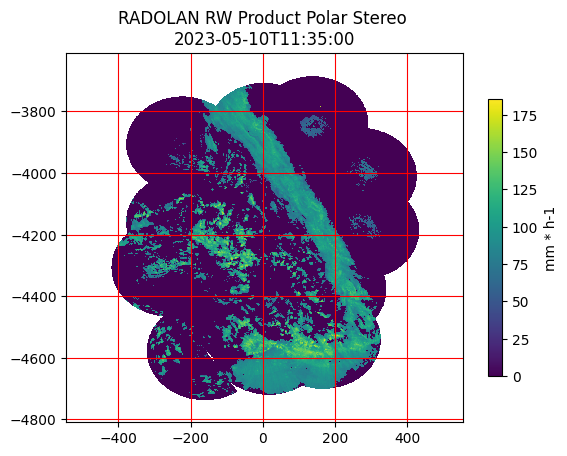

In [5]:
# do some masking
sec = rwattrs["secondary"]
rwdata.flat[sec] = -9999
rwdata = np.ma.masked_equal(rwdata, -9999)

# Get coordinates
radolan_grid_xy = wrl.georef.get_radolan_grid(1200, 1100)
x = radolan_grid_xy[:, :, 0]
y = radolan_grid_xy[:, :, 1]

# plot function
pl.pcolormesh(x, y, rwdata, cmap="viridis")
cb = pl.colorbar(shrink=0.75)
cb.set_label("mm * h-1")
pl.title("RADOLAN RW Product Polar Stereo \n" + rwattrs["datetime"].isoformat())
pl.grid(color="r")

## Use xarray backend to get data

In [6]:
ds = wrl.io.open_radolan_dataset(rw_filename)
# print the xarray dataset
ds

/home/aniket/miniconda3/envs/weather-tools/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'WN' has multiple fill values {2490, 2500, 65535}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:          (y: 1200, x: 1100, time: 1, prediction_time: 1)
Coordinates:
  * time             (time) datetime64[ns] 2023-05-10T11:35:00
  * y                (y) float64 -4.822e+06 -4.821e+06 ... -3.624e+06 -3.623e+06
  * x                (x) float64 -5.432e+05 -5.422e+05 ... 5.548e+05 5.558e+05
  * prediction_time  (prediction_time) datetime64[ns] 2023-05-10T11:35:00
Data variables:
    WN               (y, x) float32 ...
Attributes:
    radarid:         10000
    formatversion:   5
    radolanversion:  P300004H
    radarlocations:  ['']
    predictiontime:  0
    moduleflag:      8

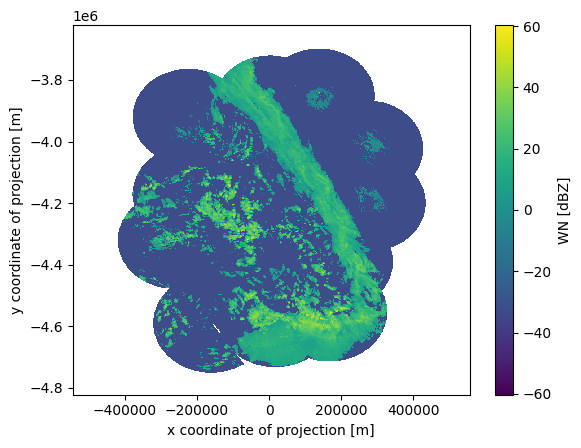

In [7]:
ds.WN.plot(cmap="viridis")

using xr.open_dataset

/home/aniket/miniconda3/envs/weather-tools/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'WN' has multiple fill values {2490, 2500, 65535}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:          (y: 1200, x: 1100, time: 1, prediction_time: 1)
Coordinates:
  * time             (time) datetime64[ns] 2023-05-10T11:35:00
  * y                (y) float64 -4.822e+06 -4.821e+06 ... -3.624e+06 -3.623e+06
  * x                (x) float64 -5.432e+05 -5.422e+05 ... 5.548e+05 5.558e+05
  * prediction_time  (prediction_time) datetime64[ns] 2023-05-10T11:35:00
Data variables:
    WN               (y, x) float32 ...
Attributes:
    radarid:         10000
    formatversion:   5
    radolanversion:  P300004H
    radarlocations:  ['']
    predictiontime:  0
    moduleflag:      8

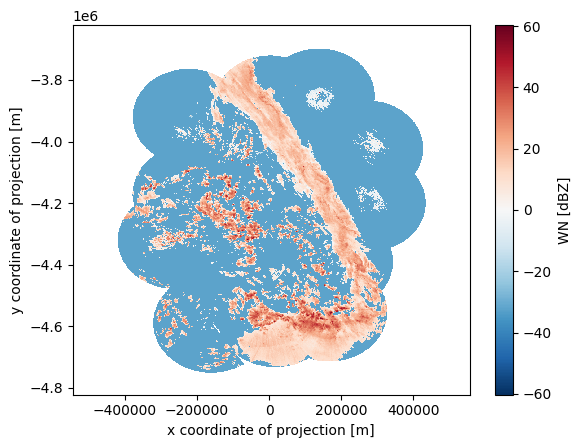

In [8]:
ds = xr.open_dataset(rw_filename, engine="radolan")
ds.WN.plot()
ds

In [9]:
filehandle = wrl.io.get_radolan_filehandle(rw_filename)
header = wrl.io.read_radolan_header(filehandle)

print(f"header: {header}")

attrs = wrl.io.parse_dwd_composite_header(header)
print(f"attrs: {attrs}")

header: WN101135100000523BY   2640094VS 5SW P300004HPR E-01INT   5GP1200x1100VV 000MF 00000008MS  2<>
attrs: {'producttype': 'WN', 'datetime': datetime.datetime(2023, 5, 10, 11, 35), 'radarid': '10000', 'datasize': 2640000, 'formatversion': 5, 'maxrange': '100 km', 'radolanversion': 'P300004H', 'precision': 0.1, 'intervalseconds': 300, 'nrow': 1200, 'ncol': 1100, 'radarlocations': [''], 'predictiontime': 0, 'moduleflag': 8}


## Convert Radolan file to geotiff file.

In [10]:
filename = "/home/aniket/infocusp/anthromet/weather-tools-aniket/dump/raa01-sf_10000-1408102050-dwd---bin.gz"
filename = wrl.util.get_wradlib_data_file(filename)
data_raw, meta = wrl.io.read_radolan_composite(filename)

In [11]:
proj_osr = wrl.georef.create_osr("dwd-radolan")

print(type(proj_osr))

# Get projected RADOLAN coordinates for corner definition
xy_raw = wrl.georef.get_radolan_grid(900, 900)

<class 'osgeo.osr.SpatialReference'>


In [12]:
data, xy = wrl.georef.set_raster_origin(data_raw, xy_raw, "upper")

In [13]:
# data = np.stack((data, data + 100, data + 1000))
ds = wrl.georef.create_raster_dataset(data, xy, projection=proj_osr)
ds

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fcabb959c00> >

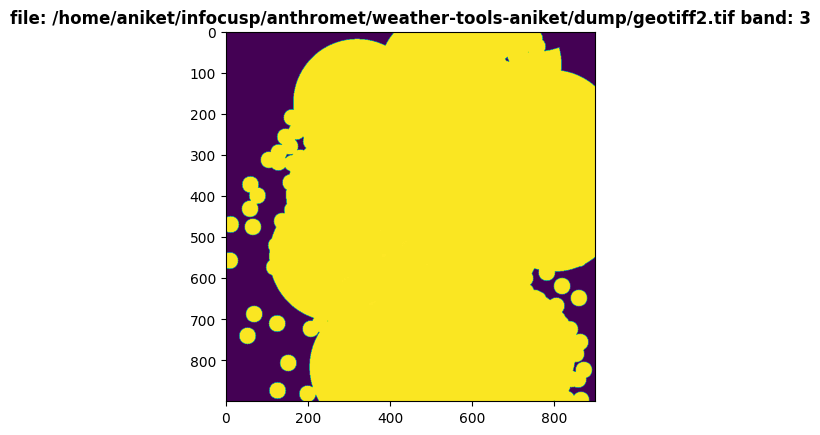

In [14]:
# wrl.io.write_raster_dataset("/home/aniket/infocusp/anthromet/weather-tools-aniket/dump/" + "geotiff.tif", ds, "GTiff")
view(uri="/home/aniket/infocusp/anthromet/weather-tools-aniket/dump/geotiff2.tif", band=3)

## Warp Radolan data to GTIFF
https://github.com/till90/master-thesis/blob/master/wradlib_warp_translate.ipynb

In [15]:
from osgeo import osr

In [16]:
#create the necessary Spatial Reference Objects for the RADOLAN-projection 
proj_stereo = wrl.georef.create_osr("dwd-radolan") #create osr object
proj_wgs = osr.SpatialReference()
proj_wgs.ImportFromEPSG(4326)
radolan_grid_xy = wrl.georef.get_radolan_grid(1200,1100)

# create Gauss Krueger zone 3 projection osr object
proj_gk3 = osr.SpatialReference()
proj_gk3.ImportFromEPSG(31467) #dhdn3

# transform radolan polar stereographic projection to wgs84 and then to gk3
radolan_grid_ll = wrl.georef.reproject(radolan_grid_xy,
                                       projection_source=proj_stereo,
                                       projection_target=proj_wgs)
radolan_grid_gk = wrl.georef.reproject(radolan_grid_ll,
                                       projection_source=proj_wgs,
                                       projection_target=proj_gk3)

In [17]:
rw_filename = wrl.util.get_wradlib_data_file(
    "/home/aniket/infocusp/anthromet/weather-tools-aniket/dump/dwd_radolan/WN2305101135_000"
)
data_raw, meta  = wrl.io.read_radolan_composite(rw_filename)


In [19]:
data, xy = wrl.georef.set_raster_origin(data_raw, radolan_grid_gk, 'upper')
ds_gk3 = wrl.georef.create_raster_dataset(data, xy, proj_gk3, -9999)
wrl.io.write_raster_dataset("/home/aniket/infocusp/anthromet/weather-tools-aniket/out5.tif", ds_gk3, "GTiff")

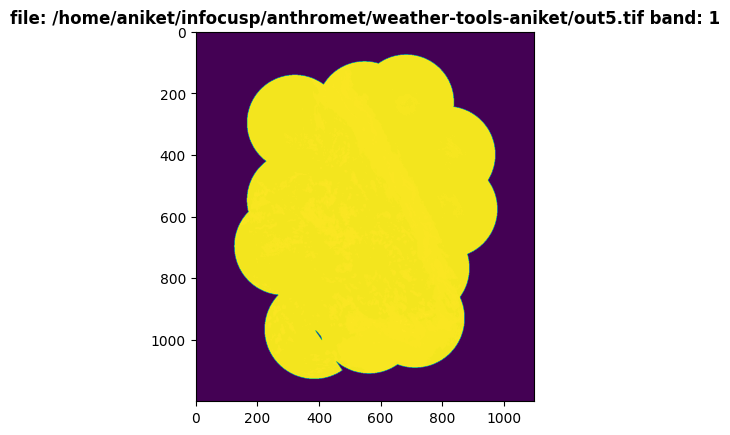

In [20]:
view(uri="/home/aniket/infocusp/anthromet/weather-tools-aniket/out5.tif")

# simple steps

In [61]:

import osgeo

data_raw_s = np.around(data_raw)

# Create Spatail Reference (Radolan projection)
proj_osr = wrl.georef.create_osr("dwd-radolan")

#Load EPSG 3857 
epsg_3857 = wrl.georef.epsg_to_osr(3857)

# Get projected RADOLAN coordinates for corner definition
xy_raw = wrl.georef.get_radolan_grid(1200, 1100) # row and col of raw_data

#flip the data and the coords up-down 
data, xy = wrl.georef.set_raster_origin(data_raw, xy_raw, 'upper')

#Create raster dataset: Geotiff with radolan projection
ds = wrl.georef.create_raster_dataset(data, xy, projection=proj_osr)

#Reproject dataset to EPSG 3857
ds2 = wrl.georef.reproject_raster_dataset(ds,projection_target=epsg_3857, spacing=1000)

# wrl.io.write_raster_dataset("/home/aniket/infocusp/anthromet/weather-tools-aniket/sout8.tif", ds, "GTiff")

AttributeError: 'Dataset' object has no attribute 'data'

# Writing tiff file using rasterio

In [52]:
import wradlib as wrl
import rasterio 

proj_osr = wrl.georef.create_osr("dwd-radolan")
wkt_str = proj_osr.ExportToWkt()
crs = rasterio.crs.CRS.from_wkt(wkt_str)
crs

CRS.from_wkt('PROJCS["Radolan Projection",GEOGCS["Radolan Coordinate System",DATUM["Radolan_Kugel",SPHEROID["Erdkugel",6370040,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",60],PARAMETER["central_meridian",10],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["kilometre",1000,AUTHORITY["EPSG","9036"]],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH]]')

In [91]:

nrows, ncols = 1200, 1100
radolan_grid_xy = wrl.georef.get_radolan_grid(nrows, ncols)
radolan_grid_ll = wrl.georef.get_radolan_grid(nrows, ncols)

print(radolan_grid_xy.shape)
print(radolan_grid_xy)


# Print the bounding points in (x, y).
print('-------Radolan lonlat-coordinates (easting[x], northing[y])---------')
print(f'ul = ({radolan_grid_xy[-1, 0, :][0]}, {radolan_grid_xy[-1, 0, :][1]})')
print(f'ur = ({radolan_grid_xy[-1, -1, :][0]}, {radolan_grid_xy[-1, -1, :][1]})')
print(f'lr = ({radolan_grid_xy[0, -1, :][0]}, {radolan_grid_xy[0, -1, :][1]})')
print(f'll = ({radolan_grid_xy[0, 0, :][0]}, {radolan_grid_xy[0, 0, :][1]})')

ul = (radolan_grid_xy[-1, 0, :][0], radolan_grid_xy[-1, 0, :][1])
ur = (radolan_grid_xy[-1, -1, :][0], radolan_grid_xy[-1, -1, :][1])
lr = (radolan_grid_xy[0, -1, :][0], radolan_grid_xy[0, -1, :][1])
ll = (radolan_grid_xy[0, 0, :][0], radolan_grid_xy[0, 0, :][1])


(1200, 1100, 2)
[[[ -543.46216692 -4808.64472427]
  [ -542.46216692 -4808.64472427]
  [ -541.46216692 -4808.64472427]
  ...
  [  553.53783308 -4808.64472427]
  [  554.53783308 -4808.64472427]
  [  555.53783308 -4808.64472427]]

 [[ -543.46216692 -4807.64472427]
  [ -542.46216692 -4807.64472427]
  [ -541.46216692 -4807.64472427]
  ...
  [  553.53783308 -4807.64472427]
  [  554.53783308 -4807.64472427]
  [  555.53783308 -4807.64472427]]

 [[ -543.46216692 -4806.64472427]
  [ -542.46216692 -4806.64472427]
  [ -541.46216692 -4806.64472427]
  ...
  [  553.53783308 -4806.64472427]
  [  554.53783308 -4806.64472427]
  [  555.53783308 -4806.64472427]]

 ...

 [[ -543.46216692 -3611.64472427]
  [ -542.46216692 -3611.64472427]
  [ -541.46216692 -3611.64472427]
  ...
  [  553.53783308 -3611.64472427]
  [  554.53783308 -3611.64472427]
  [  555.53783308 -3611.64472427]]

 [[ -543.46216692 -3610.64472427]
  [ -542.46216692 -3610.64472427]
  [ -541.46216692 -3610.64472427]
  ...
  [  553.53783308 -361

In [92]:
import rasterio

transform = rasterio.transform.from_bounds(ll[0], ll[1], ur[0], ur[1], width=ncols, height=nrows)

transform

Affine(0.9990909090909091, 0.0, -543.4621669218559,
       0.0, -0.9991666666666666, -3609.644724265573)

In [93]:
ds = xr.open_dataset("/home/aniket/infocusp/anthromet/weather-tools-aniket/dump/dwd_radolan/WN2305101150_000", engine="radolan")



#flipping data upside down
flipped_WN = xr.DataArray(np.flipud(ds['WN'].values), coords={'y': ds['y'], 'x': ds['x']}, dims=['y','x'])
ds['WN'] = flipped_WN

data = list(ds.values())

list(ds.data_vars)

ds




/home/aniket/miniconda3/envs/weather-tools/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'WN' has multiple fill values {2490, 2500, 65535}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:          (y: 1200, x: 1100, time: 1, prediction_time: 1)
Coordinates:
  * time             (time) datetime64[ns] 2023-05-10T11:50:00
  * y                (y) float64 -4.822e+06 -4.821e+06 ... -3.624e+06 -3.623e+06
  * x                (x) float64 -5.432e+05 -5.422e+05 ... 5.548e+05 5.558e+05
  * prediction_time  (prediction_time) datetime64[ns] 2023-05-10T11:50:00
Data variables:
    WN               (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    radarid:         10000
    formatversion:   5
    radolanversion:  P300004H
    radarlocations:  ['']
    predictiontime:  0
    moduleflag:      8

In [94]:
from rasterio.io import MemoryFile
from apache_beam.io.filesystems import FileSystems
import shutil

with MemoryFile() as memfile:
    with memfile.open(
        driver='COG',
        dtype='float64',
        width=data[0].data.shape[1],
        height=data[0].data.shape[0],
        count=len(data),
        nodata=np.nan,
        crs=crs,
        transform=transform,
        compress='lzw'
    ) as f:
        for i, da in enumerate(data):
            f.write(da, i+1)
    
    with FileSystems().create("/home/aniket/infocusp/anthromet/weather-tools-aniket/dump/test14.tif") as dst:
        shutil.copyfileobj(memfile, dst)

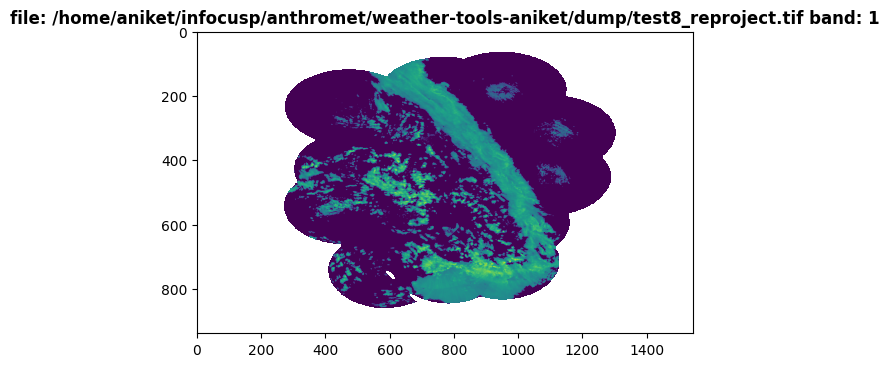

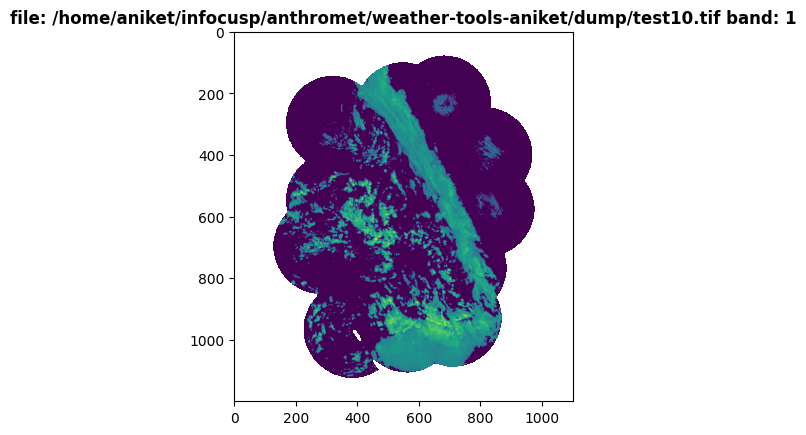

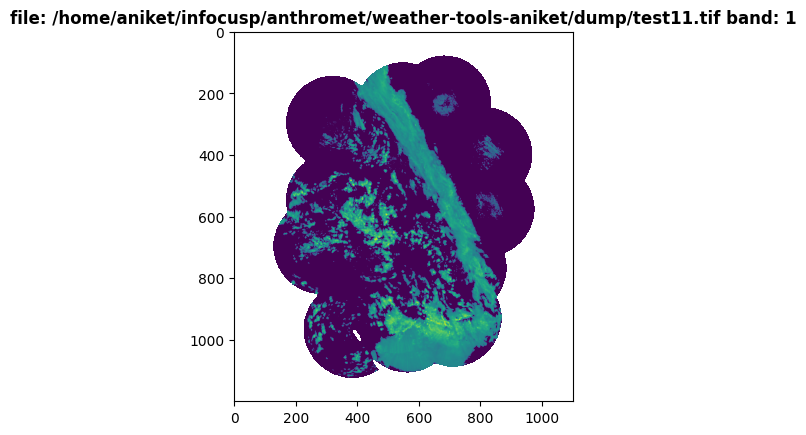

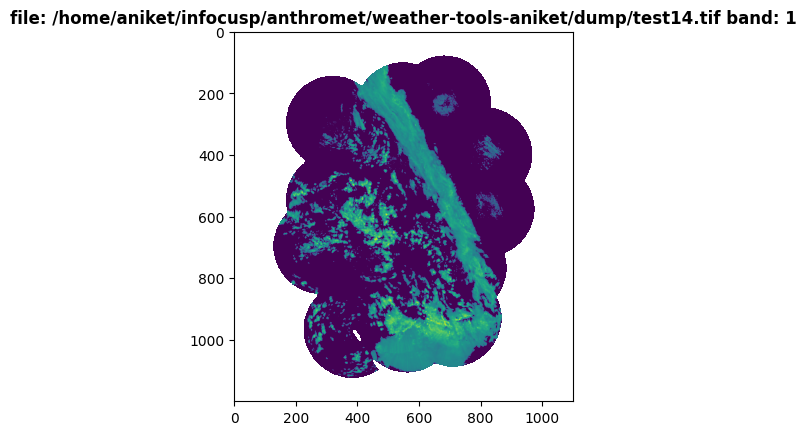

In [95]:
view(uri="/home/aniket/infocusp/anthromet/weather-tools-aniket/dump/test8_reproject.tif")
view(uri="/home/aniket/infocusp/anthromet/weather-tools-aniket/dump/test10.tif")
view(uri="/home/aniket/infocusp/anthromet/weather-tools-aniket/dump/test11.tif")
view(uri="/home/aniket/infocusp/anthromet/weather-tools-aniket/dump/test14.tif")